In [2]:
!pip install keras_nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras_nlp
import os
import json
import sklearn.model_selection
import sklearn.utils

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p data
!wget -O "/content/drive/MyDrive/data/cleaned_data.csv" "https://drive.google.com/uc?export=download&id=1suB63z-B6lPLk1mkQaIdkn1-5ydB5Uvq"

--2024-12-08 09:08:32--  https://drive.google.com/uc?export=download&id=1suB63z-B6lPLk1mkQaIdkn1-5ydB5Uvq
Resolving drive.google.com (drive.google.com)... 173.194.216.100, 173.194.216.113, 173.194.216.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1suB63z-B6lPLk1mkQaIdkn1-5ydB5Uvq&export=download [following]
--2024-12-08 09:08:32--  https://drive.usercontent.google.com/download?id=1suB63z-B6lPLk1mkQaIdkn1-5ydB5Uvq&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13018879 (12M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/data/cleaned_data.csv’

/content/drive/MyDr 100%[=====

In [5]:
with open("/content/drive/MyDrive/data/cleaned_data.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")
    print(f"The third line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

statement,status

The second line (first data point) looks like this:

hasn  get beter year ago feling try ha get worse mater try  god  try schol  try find job  try shower blah blah blah  lazy hair greasy smel  fucking failure don  act higher fail exam got fire didn  schol work fuck go lok  aford thing blame like  fault  aford shampo  aford fod  aford car fucking leson couldn  wash clothes wek shouldn  smel sory let pul imaginary washing machine imaginary money buy car imaginary money buy game fod soap fuck don  don  fucking money let  forget fact parent haven  work properly year shit owe don  deal shit lok disgust come lazy don  want walk metre don  proper conversation wo nt talk completely forget  fucking try best exam best shower eat job don  live diferent  try best kil fucking day thought didn  disapear get hospital know place laugh go reason don  jump car don  want mes leave box tablet botle morphine  sure kil  ok,Depression

The third line (f

In [6]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'
FILENAME = "drive/MyDrive/data/cleaned_data.csv"

In [7]:
from pathlib import Path

my_file = Path(FILENAME)

if my_file.is_file():
    print("File exists")
else:
    print("File does not exist")


File exists


In [8]:
sentences = []
labels = []

with open(FILENAME, 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

In [9]:
sequence_lengths = [len(sentence.split()) for sentence in sentences]
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("90th percentile:", np.percentile(sequence_lengths, 90))

Mean length: 57.96059946128718
Median length: 39.0
90th percentile: 125.0


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

In [11]:
train_size = int(len(sentences) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 27918 sentence-label pairs for training.

There are 6980 sentence-label pairs for validation.



In [12]:
# clean memory
del sentences
del labels
del dataset

In [13]:
# comment this code if there's already vocab output file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_statement,
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='mental_vocab_subwords.txt'
)

# Initialize the subword tokenizer
vectorizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./mental_vocab_subwords.txt'
)

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 9099 words



In [14]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.

    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)

    return label_encoder

In [15]:
# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Depression', 'Suicidal', 'Normal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']


In [16]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [17]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)
test_sequences_subword = test_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels_encoded)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 873
Number of batches in the validation dataset: 219


In [18]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 500)
Shape of the validation batch: (32, 500)


In [20]:
train_labels_numpy = np.array(list(train_labels_encoded))

# Tentukan kelas yang ada di dataset Anda
classes = np.unique(train_labels_numpy)  # atau manual, misalnya classes = [0, 1, 2, 3, 4, 5, 6]

# Menghitung class weights
class_weights = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels_numpy
)

# Membuat dictionary class weights
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

print(f"Class weights: {class_weight_dict}")

Class weights: {0: 0.3628353087960075, 1: 0.5474654377880185, 2: 1.4038316488158094, 3: 1.6694373019195121, 4: 2.0696864111498257, 5: 2.2218861918026263, 6: 5.7885133734190335}


In [19]:
# Hyperparameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 8
DENSE_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(vectorizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(32, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [21]:
checkpoint_path = '/content/drive/MyDrive'
checkpoint_model_filepath = checkpoint_path+"/checkpoint.weights.h5"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "train_loss": [], "train_accuracy": [],
                        "val_loss": [], "val_accuracy": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch + 1))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch + 1)
        self.history["train_loss"].append(logs.get("loss"))
        self.history["train_accuracy"].append(logs.get("accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_accuracy"].append(logs.get("val_accuracy"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         582,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 32)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 64)            │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 599,207 (2.29 MB)

 Trainable params: 599,207 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
example_batch = train_dataset_final.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 7)


In [24]:
num_of_epoch = 20

In [25]:
# run this code to reset all checkpoints
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

No saved epoch found


In [26]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

Resuming training from epoch 44


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [35]:
print(f"start_epoch: {start_epoch}, num_of_epoch: {num_of_epoch}")
start_epoch=0

start_epoch: 0, num_of_epoch: 20


In [ ]:
history = model.fit(
    train_dataset_final,
    epochs=num_of_epoch,
    initial_epoch=start_epoch,
    validation_data=test_dataset_final,
    class_weight=class_weight_dict,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback,
    ]
)

Epoch 1/20
406/873 ━━━━━━━━━━━━━━━━━━━━ 1:33 200ms/step - accuracy: 0.1665 - loss: 1.9016

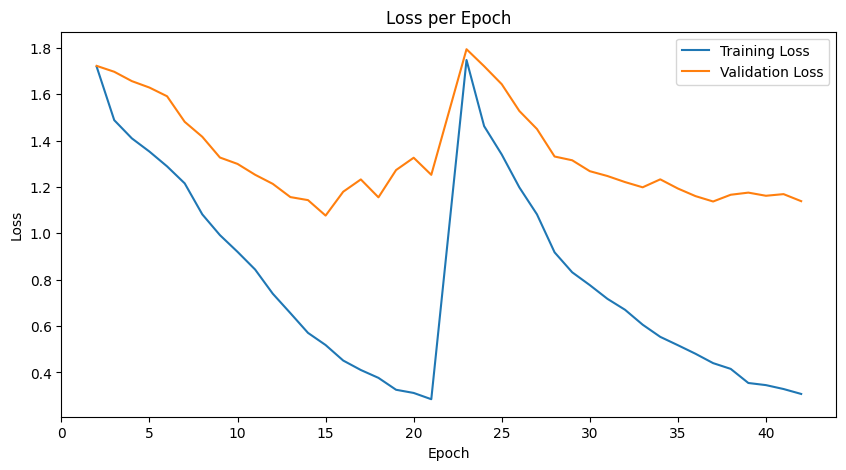

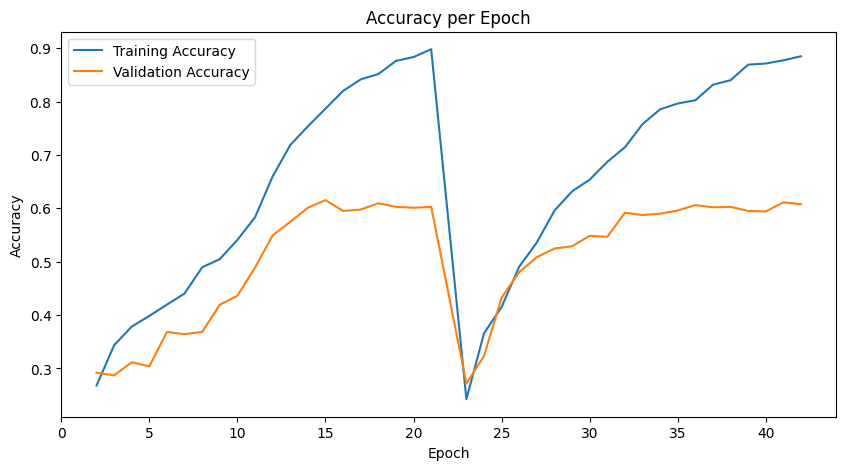

In [ ]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

In [ ]:
# Get the vocabulary
imdb_vocab_fullword = vectorizer.get_vocabulary()

# Define sample sentence
sample_string = "i cant take it anymore"

# Encode using the plain text tokenizer
tokenized_string = vectorizer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [  11    5  864   60 4248   75]
The original string: i c ##ant take it anymore


In [ ]:
rawtext_test = ["i'm depressed i can't take it anymore"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(vectorizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  11    1   15 ...   60 4248   75]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]], shape=(500, 14), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.04889917 0.15205307 0.17567208 ... 0.03794309 0.120869   0.03230912]
 [0.0349705  0.18690535 0.2263463  ... 0.02774766 0.08476866 0.03659817]
 [0.0349705  0.18690535 0.2263463  ... 0.02774766 0.08476866 0.03659817]
 ...
 [0.0349705  0.18690535 0.2263463  ... 0.02774766 0.08476866 0.03659817]
 [0.0349705  0.18690538 0.22634637 ... 0.02774766 0.08476867 0.03659818]
 [0.0349705  0.18690538 0.22634637 ... 0.02774766 0.08476866 0.03659818]]
Predicted class: Normal


In [ ]:
# Run this if you happy with the model
with open("label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save('second_iteration.keras')